In [10]:
from ppget.source import ModelSource, prepare_filesystem

WINDOW = 4
MODEL_NAME = "model/cnn1d_time_cluster/"

start_date = "2007-07-01"
end_date = "2008-08-06"
feature = "Global_active_power"

prepare_filesystem(MODEL_NAME)
source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [11]:
series = source.series()
series.head()

timestamp
2007-07-01 00:00:00    2.6812
2007-07-01 00:10:00    2.6502
2007-07-01 00:20:00    2.6266
2007-07-01 00:30:00    2.5242
2007-07-01 00:40:00    2.6000
Freq: 10T, Name: Global_active_power, dtype: float64

In [12]:
from ppget.training import DatasetBuilder, TrainSplit

WINDOW = 4
MODEL_NAME = "model/gru/"

builder = DatasetBuilder(series, data_split=TrainSplit(), window_size=WINDOW)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((52095, 4, 1), (52095,), (5789, 4, 1), (5789,))

In [13]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Dense, GRU, Dropout
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(InputLayer((WINDOW, 1)))
model.add(GRU(8))
model.add(Dense(4, 'relu'))
model.add(Dense(1, 'linear'))
callbacks = [ModelCheckpoint(MODEL_NAME, monitor="val_loss", save_best_only=True, mode="min"), EarlyStopping(patience=4, monitor="val_loss")]
model.compile(loss="mse", optimizer="adam", metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 8)                 240       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
h = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=callbacks)
print(f"min RMSE(validation): {min(h.history['val_loss'])}")

Epoch 1/100
2605/2605 - 16s - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
INFO:tensorflow:Assets written to: model/gru/assets
Epoch 2/100
2605/2605 - 15s - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607
INFO:tensorflow:Assets written to: model/gru/assets
Epoch 3/100
2605/2605 - 14s - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602
INFO:tensorflow:Assets written to: model/gru/assets
Epoch 4/100
2605/2605 - 15s - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0596
INFO:tensorflow:Assets written to: model/gru/assets
Epoch 5/100
2605/2605 - 10s - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 6/100
2605/2605 - 15s - loss: 0.0038 - root_mean_squared_error: 0.0619 - val_loss: 0.0036 - val_root_mean_squared_er

In [15]:
%%time
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

CPU times: user 4.38 s, sys: 443 ms, total: 4.82 s
Wall time: 4.12 s


5789

In [16]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results.head()

,Predictions,Ground Truth
0,0.167532,0.223336
1,0.199520,0.103952
2,0.100868,0.032003
3,0.053430,0.104497
4,0.114705,0.205604


In [17]:
from ppget.metrics import ModelEvaluation

print(ModelEvaluation(expected=test_results["Ground Truth"][:-1],
                      predicted=test_results["Predictions"].shift(-1)[:-1],
                      m=1,
                      model_path=MODEL_NAME,
                      builder=builder))

Model Scores - (R2): 0.972, (Adj R2): 0.972, (RMSE): 0.199 KW. Model Size - 541315 bytes.


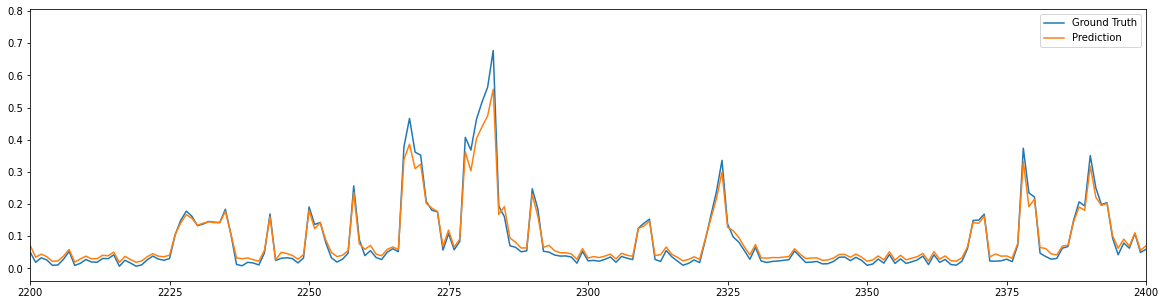

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test_results["Ground Truth"], label="Ground Truth")
ax.plot(test_results["Predictions"].shift(-1), label="Prediction")

plt.legend(["Ground Truth", "Prediction"])
plt.xlim([2200, 2400])
plt.show()